# 4장 신경망 활용: 분류와 회귀

__감사말__: 프랑소와 숄레의 [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) 3장에 사용된 코드에 대한 설명을 담고 있으며 텐서플로우 2.6 버전에서 작성되었습니다. 소스코드를 공개한 저자에게 감사드립니다.

__구글 코랩 설정__: '런타임 -> 런타임 유형 변경' 메뉴에서 GPU를 지정한다.
이후 아래 명령어를 실행했을 때 오류가 발생하지 않으면 필요할 때 GPU가 자동 사용된다.

```
!nvidia-smi
```

구글 코랩에서 사용되는 tensorflow 버전을 확인하려면 아래 명령문을 실행한다.

```python
import tensorflow as tf
tf.__version__
```

tensorflow가 GPU를 사용하는지 여부를 알고 싶으면 
주피터 노트북 등 사용하는 편집기 및 파이썬 터미널에서 아래 명령문을 실행한다.

```python
import tensorflow as tf
tf.config.list_physical_devices('GPU')
```

## 주요 내용

- 머신러닝 실전 예제: 분류와 회귀
    - 이항 분류
    - 다중 클래스 분류
    - 회귀    

## 4.1 영화 리뷰 분류: 이항 분류

영화 리뷰가 긍정적인지 부정적인지를 판단하는 이항 분류 모델을 구성한다.

### IMDB 데이터셋

- 크기: 50,000
    - 긍정 리뷰: 25,000
    - 부정 리뷰: 25,000

**IMDB 데이터셋 불러오기**

- 케라스에서 훈련 세트와 테스트 세트로 분류된 형태로 제공됨.
- `num_words=10000`: 가장 많이 사용되는 10,000개의 단어로만 구성된 리뷰를 불러오도록 지정
- 원래 총 88,585개의 단어가 사용되지만 나머지는 어쩌다 한 번 하나의 리뷰에서 사용되어 클래스 분류에 거의 도움되지 않음.

In [1]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17473536/17464789 [==============================] - 2s 0us/step


훈련 세트, 테스트 세트의 크기 모두 25,000이다.

In [2]:
len(train_data)

25000

In [3]:
len(test_data)

25000

각 샘플은 `num_words=10000`에 의해 1~9999 사이의 정수로 이루어진 리스트이다. 
최솟값은 1, 최댓값은 9999임은 아래와 같이 확인한다.

In [4]:
min([min(sequence) for sequence in train_data])

1

In [5]:
max([max(sequence) for sequence in train_data])

9999

샘플들의 크기는 서로 다르다.

In [6]:
len(train_data[0])

218

In [7]:
len(train_data[1])

189

0번 샘플의 처음 10개 값은 다음과 같다.

In [8]:
train_data[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

각 샘플의 레이블은 0(부정) 또는 1(긍정)이다.

In [9]:
train_labels[0]

1

In [10]:
test_labels[0]

0

**리뷰 내용 확인하기**

*주의사항: 모델 훈련을 위해 반드시 필요한 사항은 아님!*

- 정수와 단어 사이의 관계를 담은 사전 객체 가져오기

In [11]:
word_index = imdb.get_word_index()

1654784/1641221 [==============================] - 0s 0us/step


`word_index`에 포함된 10개 항목을 확인하면 다음과 같다.

In [12]:
for item in list(word_index.items())[:10]:
    print(item)

('fawn', 34701)
('tsukino', 52006)
('nunnery', 52007)
('sonja', 16816)
('vani', 63951)
('woods', 1408)
('spiders', 16115)
('hanging', 2345)
('woody', 2289)
('trawling', 52008)


In [13]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

`reverse_word_index`에 포함된 10개 항목을 확인하면 다음과 같다.

In [14]:
for item in list(reverse_word_index.items())[:10]:
    print(item)

(34701, 'fawn')
(52006, 'tsukino')
(52007, 'nunnery')
(16816, 'sonja')
(63951, 'vani')
(1408, 'woods')
(16115, 'spiders')
(2345, 'hanging')
(2289, 'woody')
(52008, 'trawling')


첫째 리뷰 내용을 아래와 같이 확인할 수 있다.

- 단어 인덱스에서 3을 빼야 함. 
- 인덱스 0, 1, 2는 각각 여백, 문장 시작, 불분명을 의미함.

In [15]:
first_review = train_data[0]

decoded_review = " ".join(
    [reverse_word_index.get(i-3, "?") for i in first_review])

decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

### 데이터 전처리: 벡터화

정수들의 리스트, 그것도 길이가 다른 여러 개의 리스트를 신경망의 입력값으로 사용할 수 없다. 
또한 모든 샘플의 길이를 통일시킨다 하더라도 정수들의 리스트를 직접 신경망 모델의 입력값으로 
사용하려면 나중에 다룰 `Embedding` 층(layer)과 같은 전처리 층을 사용해야 한다. 
여기서는 대신에 **멀티-핫-인코딩**을 이용하여 정수들의 리스트를
0과 1로만 이루어진 일정한 길이의 벡터(1차원 어레이)로 변환한다. 

#### 멀티-핫-인코딩

앞서 보았듯이 리뷰 리스트에 사용된 숫자들은 1부터 9999 사이의 값이다.
따라서 하나의 리뷰를 길이가 10,000인 1차원 어레이로 변환할 수 있으며,
리뷰 리스트에 항목으로 포함된 값들을 새로운 어레이의 인덱스로 사용하여,
해당 인덱스엔 1을, 나머지는 0으로 채우는 방식으로 리뷰 데이터셋을
변환시킨다.

예를 들어, `[1, 18, 13]`은 길이가 10,000인 1차원 어레이(벡터)로 변환되는데
1번, 18번, 13번 인덱스의 항목만 1이고 나머지는 0으로 채워진다.
이러한 변환을 **멀티-핫-인코딩**(multi-hot-encoding)이라 부른다.
다음 `vectorize_sequences()` 함수는 앞서 설명한 멀티-핫-인코딩을 
모든 주어진 샘플에 대해 실행한다.

이처럼 각 샘플을 지정된 크기의 1차원 어레이로 변환하는 과정을 **벡터화**(vectorization)이라 한다.

In [16]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    
    for i, sequence in enumerate(sequences):    # 모든 샘플에 대한 멀티-핫-인코딩
        for j in sequence:
            results[i, j] = 1.
    return results

이제 훈련 세트와 테스트 세트를 벡터화한다.

In [17]:
x_train = vectorize_sequences(train_data).astype("float32")
x_test = vectorize_sequences(test_data).astype("float32")

첫째 훈련 샘플의 변환 결과는 다음과 같다.

In [18]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)

레이블 또한 정수 자료형에서 `float32` 자료형으로 변환해서 자료형을 일치시킨다.

In [19]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

### 모델 구성

입력 샘플의 특성이 벡터(1차원 어레이)로 주어지고 
레이블이 스칼라(하나의 숫자)로 주어졌을 때 
밀집층(densely-connected layer)과
`Sequential` 모델을 이용하면 성능 좋은 모델을 얻는다. 
이때 사용하는 활성화 함수는 일반적으로 다음과 같다.

- 은닉층의 활성화 함수: 음수를 제거하는 `relu` 함수
- 이항 분류 모델의 최상위 층의 활성화 함수: 0과 1사이의 확률값을 계삲하는 `sigmoid` 함수

<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/dlp/master/slides/images/relu_sigmoid.png" style="width:700px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

몇 개의 층을 사용하는가와, 각 층마다 몇 개의 유닛(unit)을 사용하는가를
결정해야 하는데 이에 대해서 다음 장에서 자세히 설명한다.
여기서는 일단 다음과 같은 구성을 추천한다.

- 두 개의 연속된 밀집층
- 각각 16개의 유닛

**참고**:- 이항 분류 모델의 최상위 층은 스칼라 값을 출력하도록 하나의 유닛을 사용하는 
`Dense` 밀집층을 사용한다. 
또한 활성화 함수로 0과 1사이의 확률값을 계삲하는 `sigmoid`를 활성화 함수로 사용한다.

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

**모델 컴파일링**

- 옵티마이저: `"rmsprop"`
    - 일반적으로 추천되는 옵티마이저
- 손실함수: `"binary_crossentropy"` (로그 손실)
    - 확률 결과에 대한 오차 계산 용도로 최선임.
- 평가지표: `"accuracy"`
    - 분류 모델의 기본적인 평가지표

In [21]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

### 모델 훈련 검증

훈련 중인 모델을 에포크마다 검증하려면 검증 세트를 따로 지정하면 된다.
여기서는 처음 10,000개의 샘플을 검증 세트로 활용한다.

In [22]:
# 검증 세트
x_val = x_train[:10000]
y_val = y_train[:10000]

# 훈련 세트
partial_x_train = x_train[10000:]
partial_y_train = y_train[10000:]

훈련을 시작할 때 `validation_data` 옵션 인자를 지정하면 에포크마다 검증 세트를 이용하여 
훈련중인 모델을 평가한다.

- 에포크: 20
- 배치 크기: 512

In [23]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 19ms/step - loss: 0.5890 - accuracy: 0.6312 - val_loss: 0.4973 - val_accuracy: 0.8207
Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 0.3966 - accuracy: 0.8867 - val_loss: 0.3525 - val_accuracy: 0.8837
Epoch 3/20
30/30 [==============================] - 0s 11ms/step - loss: 0.2684 - accuracy: 0.9217 - val_loss: 0.2986 - val_accuracy: 0.8890
Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1994 - accuracy: 0.9415 - val_loss: 0.2852 - val_accuracy: 0.8894
Epoch 5/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1584 - accuracy: 0.9532 - val_loss: 0.2849 - val_accuracy: 0.8889
Epoch 6/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1274 - accuracy: 0.9633 - val_loss: 0.2956 - val_accuracy: 0.8848
Epoch 7/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1045 - accuracy: 0.9715 - val_loss: 0.3069 - val_accuracy: 0.8857
Epoch 8/20
30

#### `History` 객체 활용

`fit()` 함수의 반환값인 `History` 객체는 훈련 과정의 평가를 기억한다.
`history` 인스턴스 속성에 저장되는 평가지표는 다음과 같다.

In [24]:
history_dict = history.history

history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

훈련 세트와 검증 세트에 대한 에포크별 손실값의 변화를 그래프로 살펴보자.

- 훈련 세트: 손실값 계속 감소
- 검증 세트: 다섯째 에포크 전후 정체 및 상승. 과대적합(overfitting) 발생.

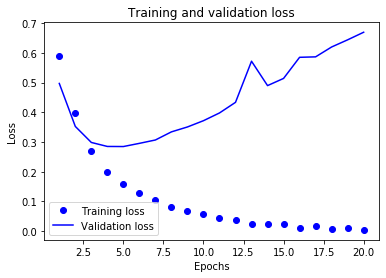

In [25]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")

plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

훈련 세트와 검증 세트에 대한 에포크별 정확도의 변화는 다음과 같다.

- 훈련 세트: 정확도 계속 증가
- 검증 세트: 다섯째 에포크 전후 정체 및 감소. 과대적합(overfitting) 발생.

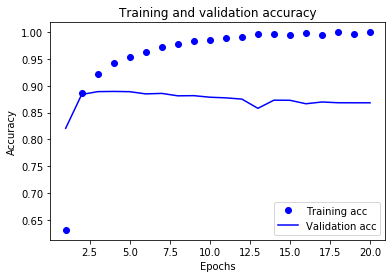

In [26]:
plt.clf()    # 이전 이미지 삭제

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")

plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### 과대적합

**과대적합**(overfitting)은 모델이 훈련 세트에 익숙해진다는 의미이다.
시험에 비유하면 연습문제의 답을 외워버리는 것을 의미한다.
과대적합을 방지하기 위한 다양한 기법은 다음 장(chapter)에서 다룬다.
위 문제의 경우 넷째 또는 다섯째 에포크 정도만 훈련 반복을 진행하면 된다.
아래 코드는 다시 처음부터 네 번의 에포크만을 사용하여 훈련한 결과를 보여준다.

In [27]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)

Epoch 1/4
49/49 [==============================] - 1s 8ms/step - loss: 0.4334 - accuracy: 0.8316
Epoch 2/4
49/49 [==============================] - 0s 8ms/step - loss: 0.2516 - accuracy: 0.9134
Epoch 3/4
49/49 [==============================] - 0s 7ms/step - loss: 0.1962 - accuracy: 0.9307
Epoch 4/4
49/49 [==============================] - 0s 7ms/step - loss: 0.1657 - accuracy: 0.9402


테스트 세트에 대한 성능은 아래와 같이 88% 정도의 정확도를 보인다.
앞으로 보다 좋은 성능의 모델을 살펴볼 것이며, 현존하는 가장 좋은 모델의 정확도는 95% 정도이다.

In [28]:
results = model.evaluate(x_test, y_test)
results

782/782 [==============================] - 1s 708us/step - loss: 0.2959 - accuracy: 0.8839


[0.2958790361881256, 0.8839200139045715]

### 모델 활용

훈련된 모델을 활용하려면 `predict()` 메서드를 이용한다.

- 0,99 이상 또는 0.01 이하의 경우: 매우 확실한 예측
- 0.4 ~ 0.6: 불확실한 예측

In [29]:
model.predict(x_test)

array([[0.28141254],
       [0.99975204],
       [0.9206085 ],
       ...,
       [0.16022724],
       [0.09620738],
       [0.62205195]], dtype=float32)

아래처럼 데이터셋이 클 경우 배치 단위로 묶어서 예측할 수도 있다.

In [30]:
model.predict(x_test, batch_size=512)

array([[0.28141254],
       [0.99975204],
       [0.9206085 ],
       ...,
       [0.16022724],
       [0.09620741],
       [0.62205195]], dtype=float32)

### 연습문제

1. 두 개의 은닉층 대신 1 개 또는 3 개의 은닉층을 사용할 때 
    검증 세트와 테스트 세트에 대한 평가지표의 변화를 확인하라.
1. 각 은닉층에 사용된 유닛(unit)의 수를 8, 32, 64 등으로 변화시킨 후 
    검증 세트와 테스트 세트에 대한 평가지표의 변화를 확인하라.
1. `binary_crossentropy` 대신 `mse`를 손실함수로 지정한 후 
    검증 세트와 테스트 세트에 대한 평가지표의 변화를 확인하라.
1. `relu` 함수 대신 이전에 많이 사용됐었던 `tanh` 함수를 손실함수로 지정한 후 
    검증 세트와 테스트 세트에 대한 평가지표의 변화를 확인하라.

## 4.2 뉴스 기사 분류: 다중 클래스 분류

### 로이터(Reuter) 데이터셋

- 1986년 로이터 통신사의 짧은 기사 모음
- 주제: 총 46개
- 주제에 따른 기사 수 다름. 하지만 주제 당 최소 10개의 기사가 훈련 세트에 포함됨.

#### 데이터셋 적재

- `num_words=10000`: 10,000등 이내의 단어만 대상으로 함.
- 데이터셋 크기: 11, 228
    - 훈련 세트 크기: 8,982
    - 테스트 세트 크기: 2,246

In [31]:
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [32]:
len(train_data)

8982

In [33]:
len(test_data)

2246

각 샘플은 정수들의 리스트이다.

In [34]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

각 샘플 리스트의 길이가 일반적으로 다르다.

In [35]:
len(train_data[11])

59

In [36]:
len(train_data[10])

31

각 샘플에 대한 레이블은 0부터 45까지의 정수로 표현된다.
예를 들어, 10번 기사의 주제는 3이다. 

In [37]:
train_labels[10]

3

주제 3은 'earn'(이익)과 연관된다.

**참고**: 아래에 언급된 46개의 주제와 번호는 정확하지 않을 수 있다.
아래 정보는 [GitHub: Where can I find topics of reuters dataset #12072](https://github.com/keras-team/keras/issues/12072)를 참조했다.

In [38]:
reuter_topics = {'cocoa': 0,
                 'grain': 1,
                 'veg-oil': 2,
                 'earn': 3,
                 'acq': 4,
                 'wheat': 5,
                 'copper': 6,
                 'housing': 7,
                 'money-supply': 8,
                 'coffee': 9,
                 'sugar': 10,
                 'trade': 11,
                 'reserves': 12,
                 'ship': 13,
                 'cotton': 14,
                 'carcass': 15,
                 'crude': 16,
                 'nat-gas': 17,
                 'cpi': 18,
                 'money-fx': 19,
                 'interest': 20,
                 'gnp': 21,
                 'meal-feed': 22,
                 'alum': 23,
                 'oilseed': 24,
                 'gold': 25,
                 'tin': 26,
                 'strategic-metal': 27,
                 'livestock': 28,
                 'retail': 29,
                 'ipi': 30,
                 'iron-steel': 31,
                 'rubber': 32,
                 'heat': 33,
                 'jobs': 34,
                 'lei': 35,
                 'bop': 36,
                 'zinc': 37,
                 'orange': 38,
                 'pet-chem': 39,
                 'dlr': 40,
                 'gas': 41,
                 'silver': 42,
                 'wpi': 43,
                 'hog': 44,
                 'lead': 45}

실제로 10번 기사 내용을 확인해보면 'earn'과 관련되어 있어 보인다.
데이터를 해독(decoding)하는 방법은 IMDB 데이터의 경우와 동일하다.

In [39]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

10번 기사 내용은 다음과 같다.

In [40]:
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in train_data[10]])

decoded_newswire

'? period ended december 31 shr profit 11 cts vs loss 24 cts net profit 224 271 vs loss 511 349 revs 7 258 688 vs 7 200 349 reuter 3'

### 데이터 전처리

**데이터 벡터화**

In [41]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

#### 원-핫-인코딩

앞서 보았듯이 레이블은 0부터 45 사이의 값이다.
이런 경우 정수를 텐서로 변환해서 사용하는 것보다
**원-핫-인코딩**(one-hot-encoding) 기법을 적용하는 게 좋다.

원-핫-인코딩은 멀티-핫-인코딩 기법과 유사하다.
차이점은 1인 오직 한 곳에서만 사용되고 나머지 항목은 모두 0이 된다.
예를 들어, 3은 길이가 46인 벡터(1차원 어레이)로 변환되는데
3번 인덱스에서만 1이고 나머지는 0이 된다.

아래 함수는 원-핫-인코딩을 실행하는 함수이다.
입력값은 레이블 데이터셋 전체를 대상으로 함에 주의하라.

In [42]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

훈련 세트의 레이블과 테스트 세트의 레이블을 인코딩한다.

In [43]:
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

인코딩된 레이블 하나를 살펴보자.

In [44]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#### `to_categorical()` 함수

원-핫-인코딩을 지원하는 함수를 케라스가 지원한다.

**참고**: 사용된 레이블의 최댓값에 1을 더한 값을 어레이의 길이로 사용한다.

In [56]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

In [57]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

**참고**: 원-핫-인코딩, 멀티-핫-인코딩 등 정수를 사용하는 데이터를 범주형 데이터로 변환하는 
전처리 과정을 지원하는 층(layer)이 있다.
예를 들어 [tf.keras.layers.CategoryEncoding 층](https://keras.io/api/layers/preprocessing_layers/categorical/category_encoding/)은 원-핫-인코딩과 멀티-핫-인코딩을 지원한다. 

### 모델 생성

**모델 정의**

IMDB 데이터셋의 경우와는 달리 3 개 이상의 클래스로 분류하는 
**다중 클래스 분류** 모델의 최종 층은 
분류해야 하는 클래스의 수 만큼의 유닛과 함께
각 클래스에 속할 확률을 계산하는 
`softmax` 활성화 함수를 이용한다.

**참고**: 각 클래스에 속할 확률을 모두 더하면 1이 되며,
가장 높은 확률을 가진 클래스를 예측값으로 사용한다.

반면에 이항 분류의 경우보다 복잡한 문제이기에 
은닉층의 유닛은 64개씩 정하여 보다 많은 정보를 상위 층으로 전달하도록 한다.

In [46]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

**모델 컴파일**

다중 클래스 분류 모델의 손실함수는 `categorical_crossentropy`을 사용한다. 
`categorical_crossentropy`는 클래스의 실제 분포와 예측 클래스의 분포 사이의 
오차를 측정하는 손실함수이며, 
자세한 내용은 생략한다.

In [47]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

### 모델 훈련 및 검증

**검증 세트 지정**

처음 1,000개의 샘플을 검증 세트 용도로 사용한다.

In [48]:
# 검증 세트
x_val = x_train[:1000]
y_val = y_train[:1000]

# 훈련 세트
partial_x_train = x_train[1000:]
partial_y_train = y_train[1000:]

**모델 훈련**

훈련 방식은 이전과 동일하다.

In [49]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 23ms/step - loss: 2.5875 - accuracy: 0.5193 - val_loss: 1.6873 - val_accuracy: 0.6690
Epoch 2/20
16/16 [==============================] - 0s 16ms/step - loss: 1.3661 - accuracy: 0.7187 - val_loss: 1.2888 - val_accuracy: 0.7210
Epoch 3/20
16/16 [==============================] - 0s 14ms/step - loss: 1.0257 - accuracy: 0.7849 - val_loss: 1.1399 - val_accuracy: 0.7590
Epoch 4/20
16/16 [==============================] - 0s 15ms/step - loss: 0.8083 - accuracy: 0.8309 - val_loss: 1.0462 - val_accuracy: 0.7740
Epoch 5/20
16/16 [==============================] - 0s 14ms/step - loss: 0.6464 - accuracy: 0.8673 - val_loss: 1.0003 - val_accuracy: 0.7790
Epoch 6/20
16/16 [==============================] - 0s 14ms/step - loss: 0.5168 - accuracy: 0.8940 - val_loss: 0.9405 - val_accuracy: 0.8080
Epoch 7/20
16/16 [==============================] - 0s 14ms/step - loss: 0.4167 - accuracy: 0.9166 - val_loss: 0.9219 - val_accuracy: 0.8040
Epoch 8/20
16

**손실값의 변화**

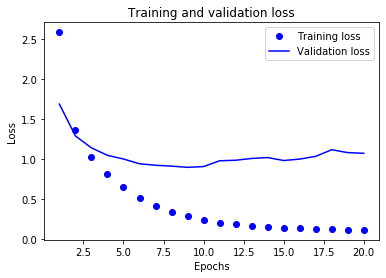

In [50]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**정확도의 변화**

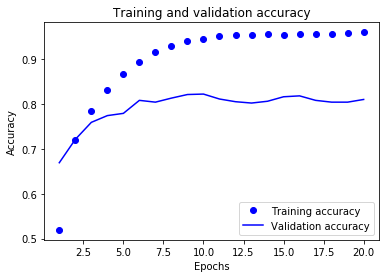

In [51]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**모델 재훈련**

9번 에포크를 지나면서 과대적합이 발생하는 것으로 보인다. 
따라서 에포크 수를 9로 줄이고 처음부터 다시 훈련시켜보자.
모델 구성부터, 컴파일, 훈련을 모두 다시 시작해야 
가중치와 편향이 초기화된 상태서 훈련을 시작한다.

In [52]:
model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(46, activation="softmax")
])

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)

Epoch 1/9
18/18 [==============================] - 1s 12ms/step - loss: 2.5358 - accuracy: 0.5560
Epoch 2/9
18/18 [==============================] - 0s 12ms/step - loss: 1.3389 - accuracy: 0.7217
Epoch 3/9
18/18 [==============================] - 0s 12ms/step - loss: 0.9803 - accuracy: 0.7904
Epoch 4/9
18/18 [==============================] - 0s 12ms/step - loss: 0.7642 - accuracy: 0.8396
Epoch 5/9
18/18 [==============================] - 0s 12ms/step - loss: 0.6097 - accuracy: 0.8717
Epoch 6/9
18/18 [==============================] - 0s 12ms/step - loss: 0.4866 - accuracy: 0.8981
Epoch 7/9
18/18 [==============================] - 0s 13ms/step - loss: 0.3910 - accuracy: 0.9197
Epoch 8/9
18/18 [==============================] - 0s 12ms/step - loss: 0.3226 - accuracy: 0.9300
Epoch 9/9
18/18 [==============================] - 0s 12ms/step - loss: 0.2658 - accuracy: 0.9390


훈련된 모델을 이용한 테스트 세트에 대한 예측의 정확도는 80% 정도이다.

In [53]:
results = model.evaluate(x_test, y_test)

results

71/71 [==============================] - 0s 1ms/step - loss: 0.9840 - accuracy: 0.7841


[0.9840289950370789, 0.784060537815094]

80%의 정확도가 얼마나 좋은지/나쁜지를 판단하려면 무작위로 찍을 때의 정확도를 계산해봐야 한다.
아래 코드가 이를 실천하며, 18~19% 정도의 정확도가 나온다.
따라서 80% 정도의 정확도는 상당히 좋은 편이다.

In [54]:
import copy

# 원 데이터를 건드리지 않기 위해 사본 사용
test_labels_copy = copy.copy(test_labels)

np.random.shuffle(test_labels_copy)
hits_array = test_labels == test_labels_copy

# 항목들의 평균값: 1 또는 0으로만 이루어졌기에 일치하는 확률을 계산함
hits_array.mean()

0.19100623330365094

### 예측하기

훈련된 모델을 테스트 세트에 적용한다.

In [58]:
predictions = model.predict(x_test)

예측값의 모두 길이가 46인 1차원 어레이다.

In [59]:
predictions[0].shape

(46,)

예측값은 46개 클래스에 들어갈 확률들로 이루어지며 합은 1이다.

In [61]:
np.sum(predictions[0])

1.0

가장 큰 확률값을 가진 인덱스가 모델이 예측하는 클래스가 된다.
예를 들어 테스트 세트의 0번 샘플(로이터 기사)은 3번 레이블을 갖는다고 예측된다.

In [62]:
np.argmax(predictions[0])

3

### 정수 레이블 사용법

정수 텐서를 이용하여 훈련하려면 모델을 컴파일할 때 손실함수로 
`sparse_categorical_crossentropy`를 
사용하면 된다.

```python
y_train = np.array(train_labels)
y_test = np.array(test_labels)

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
```

### 은닉층에 사용되는 유닛 개수

은닉층에 사용되는 유닛은 마지막 층의 유닛보다 많아야 한다.
그렇지 않으면 정보전달 과정에 병목현상(bottleneck)이 발생할 수 있다.
아래 코드의 둘째 은닉층은 4 개의 유닛만을 사용하는데 
훈련된 모델의 성능이 많이 저하된다.

In [63]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 1s 9ms/step - loss: 2.8075 - accuracy: 0.3074 - val_loss: 2.0738 - val_accuracy: 0.5750
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 1.7860 - accuracy: 0.6118 - val_loss: 1.6275 - val_accuracy: 0.6190
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1.4513 - accuracy: 0.6344 - val_loss: 1.4873 - val_accuracy: 0.6400
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1.2889 - accuracy: 0.6644 - val_loss: 1.4307 - val_accuracy: 0.6660
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 1.1875 - accuracy: 0.7031 - val_loss: 1.4057 - val_accuracy: 0.6780
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 1.1110 - accuracy: 0.7258 - val_loss: 1.4152 - val_accuracy: 0.6780
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 1.0469 - accuracy: 0.7379 - val_loss: 1.4310 - val_accuracy: 0.6870
Epoch 8/20
63/63 [==

테스트 세트에 대한 정확도가 80% 정도에서 65% 정도로 낮아졌다.

In [64]:
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 1ms/step - loss: 2.1383 - accuracy: 0.6536


[2.1382720470428467, 0.6536064147949219]

### 연습문제

1. 은닉층의 유닛 개수를 32, 128 등 여러 값으로 실험해 보아라.
1. 은닉층의 수를 1개 또는 3개로 바꿔 보아라.

## 4.3 주택 가격 예측: 회귀

### The Boston Housing Price dataset

**Loading the Boston housing dataset**

In [55]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [56]:
train_data.shape

(404, 13)

In [57]:
test_data.shape

(102, 13)

In [58]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

### Preparing the data

**Normalizing the data**

In [59]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

### Building your model

**Model definition**

In [60]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

### Validating your approach using K-fold validation

**K-fold validation**

In [61]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [62]:
all_scores

[2.024545907974243, 2.467670440673828, 2.3559298515319824, 2.5102298259735107]

In [63]:
np.mean(all_scores)

2.339594006538391

**Saving the validation logs at each fold**

In [64]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


**Building the history of successive mean K-fold validation scores**

In [65]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

**Plotting validation scores**

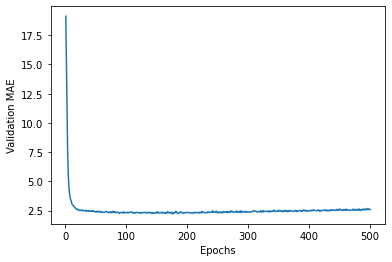

In [66]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Plotting validation scores, excluding the first 10 data points**

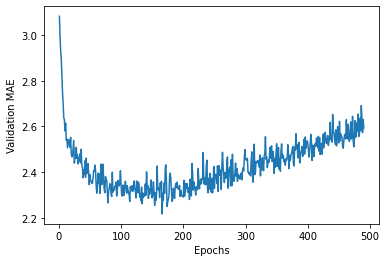

In [67]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Training the final model**

In [68]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 14.3330 - mae: 2.4183


In [69]:
test_mae_score

2.4182708263397217

### Generating predictions on new data

In [70]:
predictions = model.predict(test_data)
predictions[0]

array([6.809031], dtype=float32)

### Wrapping up

## Chapter summary